In [6]:
import pandas as pd
import numpy as np
import skrf as rf
from skrf.data import ring_slot
import matplotlib.pyplot as plt
from scipy import constants 


In [17]:
freq_line = 207
first_interesting_line = 208 
freq_line = 571
next_interesting_line = 573
freq_iter = 0

df1 = pd.DataFrame(columns = ['freq', 'zenith', 'power real, [dB]'])

filename = 'april10_2023_beam_patterns/2023.04.10.14.11.04_run3_azimuth_plane_copol_lpda.txt'

with open(filename,'r', encoding = 'unicode_escape') as handle:
    for lineno, line in enumerate(handle):
        #while lineno >= first_interesting_line and line != 'Horizontal Imaginary' :
        if lineno >= first_interesting_line:
            if (lineno - 206) % 364 == 0 :
                # freq line
                #print(line)
                freq_iter+=1
                if line == 'Horizontal Imaginary\n':
                    break
            else:
                if (lineno - 207) % 364 != 0:
                    line_ar = line.split(',')
                    ref = line_ar[1].strip('\n')
                    ref = float(ref)
                    angle = line_ar[0].strip('\t')
                    freq = (freq_iter*50) + 50
                    #print(line_ar[0], line_ar[1])
                    angle = line_ar[0]
                    angle = float(angle)
                    data_dummy =  {'freq': [freq], 'zenith': [angle], 'power real, [dB]': [ref] }
                    df_dummy = pd.DataFrame(data_dummy)
                    df1 = pd.concat([df1, df_dummy], ignore_index=True)
    freq_iter = 0
    last_line = lineno
#    print(last_line)

df2 = pd.DataFrame(columns = ['power im, [dB]'])

with open(filename,'r', encoding = 'unicode_escape') as handle:
    for lineno, line in enumerate(handle):
        if lineno >= (last_line+4):
            #print(lineno, line)
            if (lineno - 7488) % 364 == 0:
                    freq_iter+=1
                    if line == 'Horizontal Log Magnitude\n':
                        break
                        
            else:
                if (lineno - 7489 ) % 364 != 0 :
                    line_ar = line.split(',')
                    ref = line_ar[1].strip('\n')
                    ref = float(ref)
                    angle = line_ar[0].strip('\t')
                    angle = line_ar[0]
                    angle = float(angle)
                    freq = (freq_iter*50) + 50
                    data_dummy =  {'power im, [dB]': [ref] }
                    df_dummy = pd.DataFrame(data_dummy)
                    df2 = pd.concat([df2, df_dummy], ignore_index=True)

df = pd.concat([df1, df2], axis=1)
df['magnitude, db'] = 1
for i in range (0, 7239):
    df['magnitude, db'][i] =  np.sqrt( pow(df['power real, [dB]'][i],2) + pow(df['power im, [dB]'][i],2) ) 
df

/var/folders/xd/w61nhbgd1pzdh3882_n3cmz80000gn/T/ipykernel_12548/1465977182.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['magnitude, db'][i] =  np.sqrt( pow(df['power real, [dB]'][i],2) + pow(df['power im, [dB]'][i],2) )


,freq,zenith,"power real, [dB]","power im, [dB]","magnitude, db"
0,50,0.0,-0.000046,-0.000159,0.000166
1,50,1.0,-0.000177,-0.000130,0.000220
2,50,2.0,-0.000077,-0.000129,0.000150
3,50,3.0,-0.000174,-0.000133,0.000219
4,50,4.0,-0.000086,-0.000156,0.000178
...,...,...,...,...,...
7235,1000,357.0,-0.002252,0.000710,0.002362
7236,1000,358.0,-0.002283,0.000459,0.002329
7237,1000,359.0,-0.002277,0.000590,0.002352
7238,1000,360.0,-0.002441,0.000499,0.002492


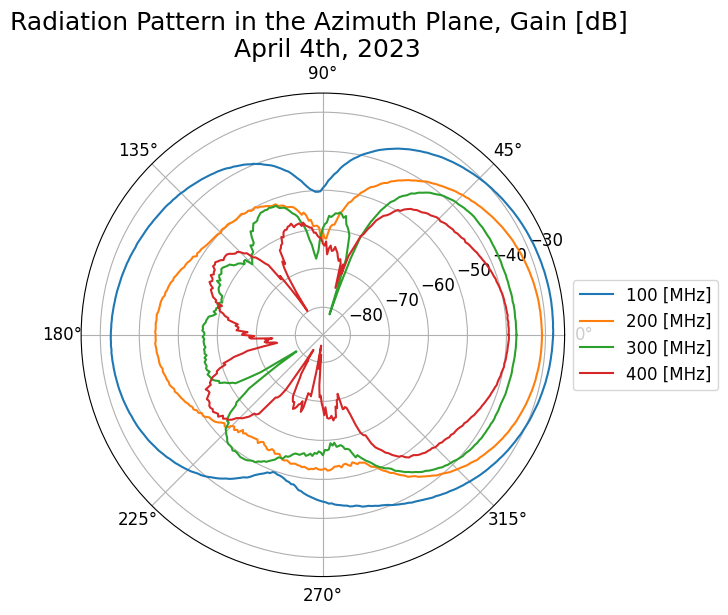

In [19]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
freq = np.array([100, 200, 300,400])

for selected_freq in freq:
    df_freq = df.iloc[:][df.freq == selected_freq]
    max_gain = df_freq['magnitude, db'].max()
    
    ax.plot(df_freq['zenith']*np.pi/180, 20*np.log10(df_freq['magnitude, db']), 
            label =  str(selected_freq)+ ' [MHz]')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    
ax.grid(True)
plt.tight_layout()
plt.title('Radiation Pattern in the Azimuth Plane, Gain [dB] \n April 4th, 2023', fontsize=18)
ax.tick_params(labelsize='large')

#plt.savefig('/Users/alisanozdrina/Desktop/pics_for_work/lpda_cross_E.png', dpi=100,bbox_inches='tight')

In [20]:
# Test Data from The VNA, forward beam measurement 
ring_slot = rf.Network('april10_2023/txrx_lpda_co_pol.s2p')
ring_slot.frequency.unit = 'hz'

## from the Friis equation for two identical antennas facing each other- 
$$\frac{P_{rx}}{P_{tx}} = \left(\frac{\lambda}{4 \pi R}\right)^2 |G|^2 $$
$$\frac{P_{rx}}{P_{tx}} = \left(|S_{12}| \right)^{2} $$
$$ \left(|S_{12}| \right) = \frac{\lambda}{4 \pi R} |G| $$
where |G| = 11 dBi according to https://www.dxengineering.com/parts/cae-clp-5130-2n#, 

$$ G [dBi]= 10 \log_{10}(G) $$

Text(0.5, 0, 'Frequency, [GHz]')

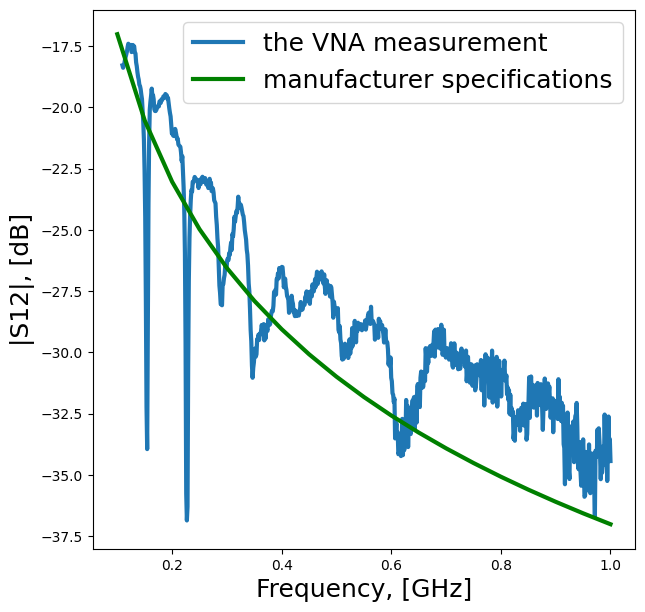

In [21]:
G_dBi = 11
G = pow(10, G_dBi/20)
freq = np.arange(100,1050,50) * 1e6 #Hz
n_air = 1.0003
c_air = constants.c/n_air #m/c
wavelength = c_air/freq
S12 = wavelength/(4*np.pi*6) * G

plt.rcParams["figure.figsize"] = (7,7)

#vna measurement 
plt.plot(ring_slot.f[50:]*1e-9,20*np.log10(ring_slot.s_mag[50:,1,0]), linewidth=3, label = 'the VNA measurement')
plt.plot(freq*1e-9,20*np.log10(S12), c='green', linewidth=3, label = 'manufacturer specifications')

plt.legend(fontsize = 18)
plt.ylabel('|S12|, [dB]', fontsize=18)
plt.xlabel('Frequency, [GHz]', fontsize=18)

#plt.savefig('/Users/alisanozdrina/Desktop/pics_for_work/s12_from_specs.png',dpi=100, bbox_inches='tight')

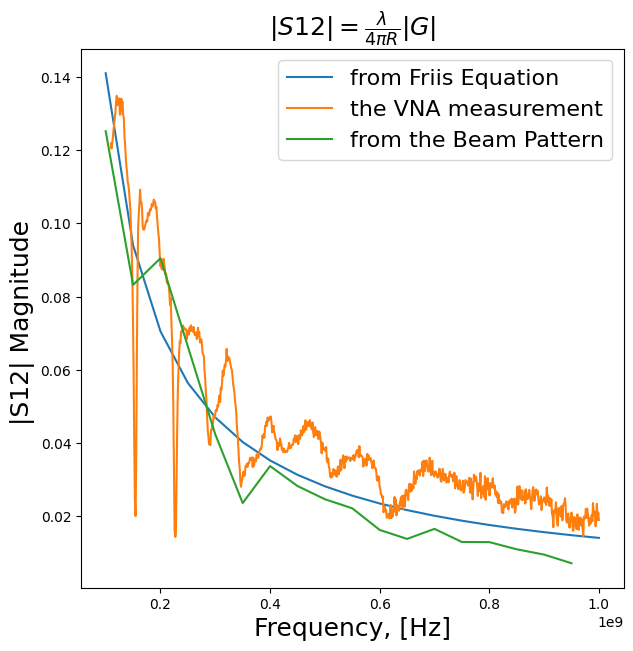

In [22]:
freq_array = np.arange(100,1000,50)

BeamPattern_co = np.zeros(len(freq_array))

phi = 0
theta = 0
    
for freq in range(len(freq_array)):
    freq_value = freq_array[freq]
    df_dummy_co = df.loc[df['freq'] == freq_value]
    df_dummy_co.reset_index()
    BeamPattern_co[freq] = df_dummy_co.iloc[phi]['magnitude, db']

freq = np.arange(100,1050,50) * 1e6 #Hz

plt.plot(freq, S12, label = 'from Friis Equation')
plt.title(r'$|S12| = \frac{\lambda}{4 \pi R} |G|$', fontsize = 18)
plt.xlabel('Frequency, [Hz]',fontsize = 18)
plt.ylabel('|S12| Magnitude ',fontsize = 18)

#forward beam vna measurement 
plt.plot(ring_slot.f[50:],ring_slot.s_mag[50:,1,0], label = 'the VNA measurement')

#forward beam extracted from the beam pattern measurements 
plt.plot(freq_array*1e6, BeamPattern_co * pow(10,10/20), label = 'from the Beam Pattern')

plt.legend(fontsize = 16)
#plt.savefig('s12',dpi=100, bbox_inches='tight')